In this notebook, we train the ODESolver model on the SEIR equation:

$$s'=-\gamma si$$
$$e'=\gamma si - \mu e$$
$$i'=\mu e-\alpha i$$
$$r'=\alpha i$$

The parameters we're estimating are: $\gamma, \mu, \alpha$

In [1]:
import sys
import torch

try:
    from torchts.nn.models.ode import ODESolver
    from torchts.utils.data import generate_ode_dataset
except:
    sys.path.append("../../../")
    from torchts.nn.models.ode import ODESolver
    from torchts.utils.data import generate_ode_dataset

import matplotlib.pyplot as plt

In [2]:
# SEIR equations
dt = 0.01

def s_prime(prev_val, coeffs):
    return - coeffs["g"]*prev_val["s"]*prev_val["i"]

def e_prime(prev_val, coeffs):
    return coeffs["g"]*prev_val["s"]*prev_val["i"] - coeffs["m"]*prev_val["e"]

def i_prime(prev_val, coeffs):
    return coeffs["m"]*prev_val["e"] - coeffs["a"]*prev_val["i"]

def r_prime(prev_val, coeffs):
    return coeffs["a"]*prev_val["i"]

ode = {"s": s_prime, "e": e_prime, "i": i_prime, "r": r_prime}

# Initial conditions [0,0,0]
ode_init = {"s": 0.1, "e": 0.9, "i": 0, "r": 0}

# Constants (Parameters)
ode_coeffs = {"a": 0.1, "g": 0.3, "m": 0.2}


# 4th Order Runge-Kutta - Data Generation for nt = 1000

In [3]:
ode_solver = ODESolver(
    ode=ode,
    init_vars=ode_init,
    init_coeffs=ode_coeffs,
    dt=dt,
    solver="rk4",
    optimizer=torch.optim.SGD,
    optimizer_args={"lr": 0.01}
)

result = ode_solver(1000)

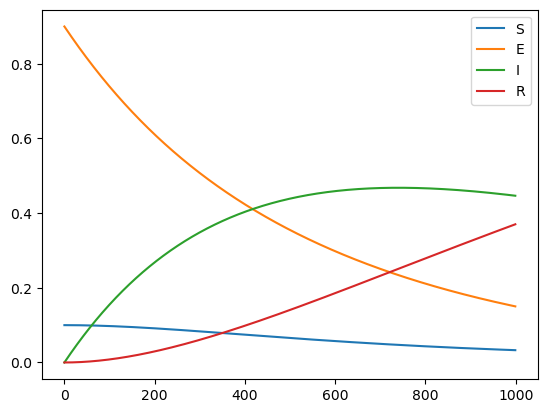

In [4]:
result_np = result.detach().numpy() # Convert to numpy array

# 2D plots
plt.plot(result_np[:,0])
plt.plot(result_np[:,1])
plt.plot(result_np[:,2])
plt.plot(result_np[:,3])

plt.legend(["S", "E", "I", "R"])

plt.show()

# Runge-Kutta method for training

In [9]:
ode_train_coeffs = {"a": torch.rand(()), "g": torch.rand(()), "m": torch.rand(())}

ode_solver_train = ODESolver(
    ode=ode,
    init_vars=ode_init,
    init_coeffs=ode_train_coeffs,
    dt=dt,
    solver="rk4",
    optimizer=torch.optim.Adam,
    optimizer_args={"lr": 0.05},
    scheduler=torch.optim.lr_scheduler.MultiStepLR,
    scheduler_args={"milestones": [5],"gamma": 0.2}
)

In [10]:
result_x, result_y = generate_ode_dataset(result)

In [11]:
ode_solver_train.fit(
    result_x,
    result_y,
    max_epochs=10,
    batch_size=64
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type | Params
------------------------------
------------------------------
3         Trainable params
0         Non-trainable params
3         Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/torchTS/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:412: UserWarning: The number of training samples (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 9: 100%|██████████| 16/16 [00:51<00:00,  3.22s/it, loss=3.02e-12, v_num=10, train_loss_step=1.93e-12, train_loss_epoch=2.73e-12]


In [12]:
ode_solver_train.get_coeffs()

{'a': 0.09999284148216248, 'g': 0.2904980182647705, 'm': 0.19979676604270935}

# Predictions for nt = 10000

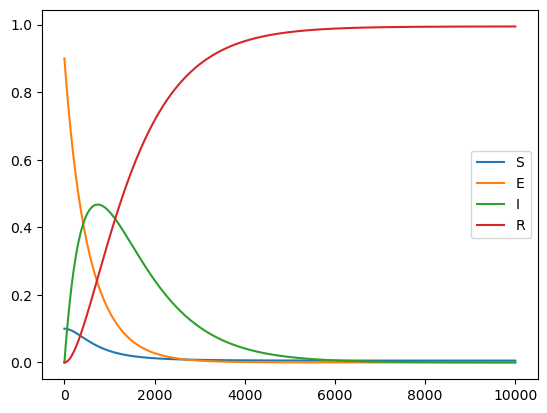

In [13]:
results_test = ode_solver_train(10000)
results_test_np = results_test.detach().numpy() # Convert to numpy array

# 2D plots
plt.plot(results_test_np[:,0])
plt.plot(results_test_np[:,1])
plt.plot(results_test_np[:,2])
plt.plot(results_test_np[:,3])

plt.legend(["S", "E", "I", "R"])

plt.show()

# Mean Squared Error Loss - Train set (nt = 1000)

In [14]:
ode_solver = ODESolver(
    ode=ode,
    init_vars=ode_init,
    init_coeffs={"a": 0.1, "g": 0.3, "m": 0.2},
    dt=0.01,
    solver="rk4",
    optimizer=None,
)

In [15]:
loss = torch.nn.MSELoss()
loss(ode_solver(1000),ode_solver_train(1000))

tensor(2.7637e-07, grad_fn=<MseLossBackward>)

# Mean Squared Error Loss - (nt = 2000)

In [16]:
loss = torch.nn.MSELoss()
loss(ode_solver(2000),ode_solver_train(2000))

tensor(3.7380e-07, grad_fn=<MseLossBackward>)

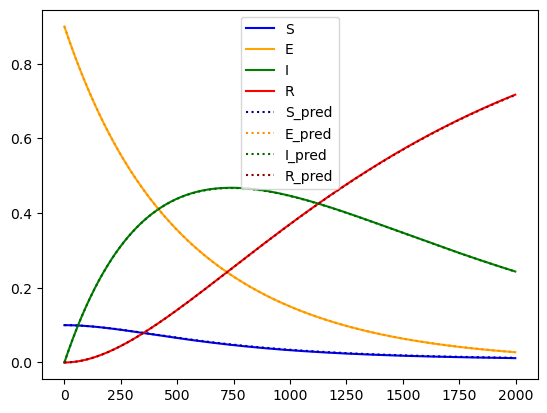

In [22]:
results_test = ode_solver(2000)
results_test_np = results_test.detach().numpy() # Convert to numpy array

results_preds = ode_solver_train(2000)
results_preds_np = results_preds.detach().numpy() # Convert to numpy array

# 2D plots
plt.plot(results_test_np[:,0], "b")
plt.plot(results_test_np[:,1], "orange")
plt.plot(results_test_np[:,2], "g")
plt.plot(results_test_np[:,3], "r")

# 2D pred plots
plt.plot(results_preds_np[:,0], "darkblue", linestyle="dotted")
plt.plot(results_preds_np[:,1], "darkorange", linestyle="dotted")
plt.plot(results_preds_np[:,2], "darkgreen", linestyle="dotted")
plt.plot(results_preds_np[:,3], "darkred", linestyle="dotted")

plt.legend(["S", "E", "I", "R", "S_pred", "E_pred", "I_pred", "R_pred"])

plt.show()